In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)



True
1
12.1


# U-Net Model

In [4]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            torch.nn.ReLU()
        )


    def forward(self, X):
        return self.step(X)

In [5]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Encoding Layers
        self.layer1 = DoubleConv(in_channels = 1, out_channels = 64)
        self.layer2 = DoubleConv(in_channels = 64, out_channels = 128)
        self.layer3 = DoubleConv(in_channels = 128, out_channels = 256)
        self.layer4 = DoubleConv(in_channels = 256, out_channels = 512)

        # Decoding Layers
        self.layer5 = DoubleConv(in_channels = 512+256, out_channels = 256) # verbunden mit layer3
        self.layer6 = DoubleConv(in_channels = 256+128, out_channels = 128) # verbunden mit layer2
        self.layer7 = DoubleConv(in_channels = 128+64, out_channels = 64) # verbunden mit layer1
        self.layer8 = torch.nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 1)

        # Pooling
        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):
        # Encoding Layers
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        # Decoding Layers
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4) # Upsample x4
        x5 = torch.cat([x5, x3], dim=1) # konkatinierte features: verbindung zwischen layer5 und layer3. Channel dim = 1
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5) 
        x6 = torch.cat([x6, x2], dim=1) 
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6) 
        x7 = torch.cat([x7, x1], dim=1) 
        x7 = self.layer7(x7)

        ret = self.layer8(x7)

        return ret

In [6]:
model = UNet()

random_input = torch.randn(1,1,256,256) # (batch size, channel dimension, pixel width, pixel height)
output = model(random_input)
assert output.shape == torch.Size([1,1,256,256])


# Training

In [7]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

from dataset import CardiacDataset

### Augmentation Pipeline
Zufällige Transformationen um robuster zu lernen

In [8]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # Zoom in or out
               rotate=(-45, 45)),  # Rotate up to 45 degrees
    iaa.ElasticTransformation()  # Random Elastic Deformations
])

### Dataset

In [9]:
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val/")

train_dataset = CardiacDataset(train_path, seq) # nur das train dataset wird augmented
val_dataset = CardiacDataset(val_path, None)

### Dataloader

In [10]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Custom Lossfunction (Dice Loss)

In [11]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask): # predicted segmentation, real segmentation
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()
        denum = pred.sum() + mask.sum() + 1e-8 #  1e-8, so that we never divide by 0
        dice = (2*counter) / denum
        return 1 - dice

In [12]:
class BrainTumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr= 1e-4)
        self.loss_fn = DiceLoss()

    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch              
        mask = mask.float() # real segmentation
        pred = self(mri) # predicted segmentation

        loss = self.loss_fn(pred, mask)

        self.log("Train Dice", loss)

        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch              
        mask = mask.float() # real segmentation
        pred = self(mri) # predicted segmentation

        loss = self.loss_fn(pred, mask)

        self.log("Val Dice", loss)

        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss
    
    def log_images(self, mri, pred, mask, name):

        pred = pred > 0.5 # Only pixels with pred > 0.5 are is segmantation class (Threshholding)
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)


    def configure_optimizers(self):
        return [self.optimizer]

In [14]:
torch.manual_seed(0)
model = BrainTumorSegmentation()

In [16]:
checkpoint_callback = ModelCheckpoint(monitor="Val Dice", save_top_k=10, mode="min")

In [18]:
trainer = pl.Trainer(devices=1, accelerator="gpu", logger=TensorBoardLogger(save_dir="logs"), log_every_n_steps=1, callbacks = checkpoint_callback, max_epochs=75)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
#trainer.fit(model, train_loader, val_loader)

# Evaluation

In [1]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera

c:\Users\Flori\anaconda3\envs\udemy\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
model = BrainTumorSegmentation.load_from_checkpoint("deployment/logs/lightning_logs/version_0/checkpoints/epoch=0-step=8719.ckpt")

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [22]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/5270 [00:00<?, ?it/s]

In [23]:
1-model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))  # two possibilities

tensor(0.)

In [24]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.0


In [67]:
subject = Path("Task01_BrainTumour/imagesTr/BRATS_008.nii.gz") # todo: change to test images
subject_mri = nib.load(subject).get_fdata()[...,0]
subject_mri.shape

(240, 240, 155)

In [52]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data

In [68]:
# subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [69]:
standardized_scan.shape

(240, 240, 155)

In [81]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        print(np.max(pred.cpu().numpy()))
        pred = pred > 0.5

    preds.append(pred.cpu())

# Function to check if any tensor contains True
def check_for_true(tensors):
    for tensor in tensors:
        if tensor.any().item():  # Check if any element is True
            return True
    return False

# Check if any tensor contains True
if check_for_true(preds):
    print("There are True values in the tensors.")
else:
    print("There are no True values in the tensors.")

2.2862855e-20
There are no True values in the tensors.


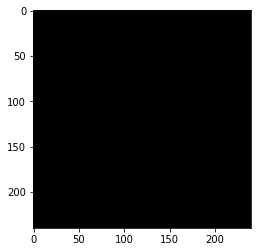

In [79]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [80]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video